In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import pathlib

In [2]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [3]:
def train_transform(dataset):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    train_dataset=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
    mean,std=get_mean_std(train_loader)
    train_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=train_transforms)
    return data_set

In [4]:
path = "../Datasets/dataset_20_classes/"
dataset=train_transform(path)

In [5]:
root=pathlib.Path(path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes=classes[1:]
print(classes)

['Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


In [6]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
print(str(train_size)+" "+str(val_size)+" "+str(test_size))

13803 1971 3945


In [7]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [8]:
device=set_device()

In [9]:
lr = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4]
Batchs=[64]
from statistics import mean
best_accuracy=0.0
best_param=""
criterion = nn.CrossEntropyLoss()
lr_accuract_training=[]
lr_accuracy_val=[]
lr_loss_train=[]
lr_loss_val=[]

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Learning Rate: 1.0000 
Batch Size: 64 
Epoch size: 50 
Epoch: 1 
Training Data: Epoch Loss: 3.280, Epoch Accuracy: 31.855, Validation Loss: 2.429,Validation Accuracy: 33.638
Epoch: 2 
Training Data: Epoch Loss: 2.412, Epoch Accuracy: 32.935, Validation Loss: 2.313,Validation Accuracy: 34.703
Epoch: 3 
Training Data: Epoch Loss: 2.273, Epoch Accuracy: 33.877, Validation Loss: 2.298,Validation Accuracy: 36.276
Epoch: 4 
Training Data: Epoch Loss: 2.129, Epoch Accuracy: 34.797, Validation Loss: 2.748,Validation Accuracy: 36.580
Epoch: 5 
Training Data: Epoch Loss: 2.096, Epoch Accuracy: 36.181, Validation Loss: 2.101,Validation Accuracy: 38.407
Epoch: 6 
Training Data: Epoch Loss: 1.954, Epoch Accuracy: 38.644, Validation Loss: 1.812,Validation Accuracy: 40.741
Epoch: 7 
Training Data: Epoch Loss: 1.797, Epoch Accuracy: 42.426, Validation Loss: 1.770,Validation Accuracy: 40.589
Epoch: 8 
Training Data: Epoch Loss: 1.771, Epoch Accuracy: 43.121, Validation Loss: 1.941,Validation Accuracy: 

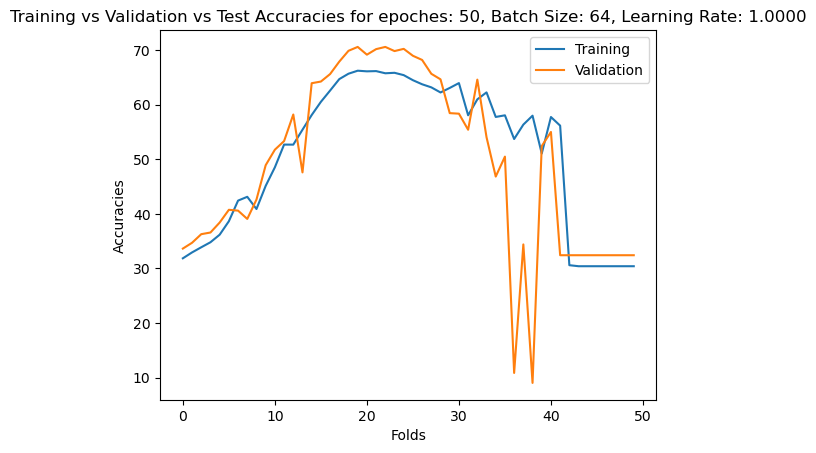

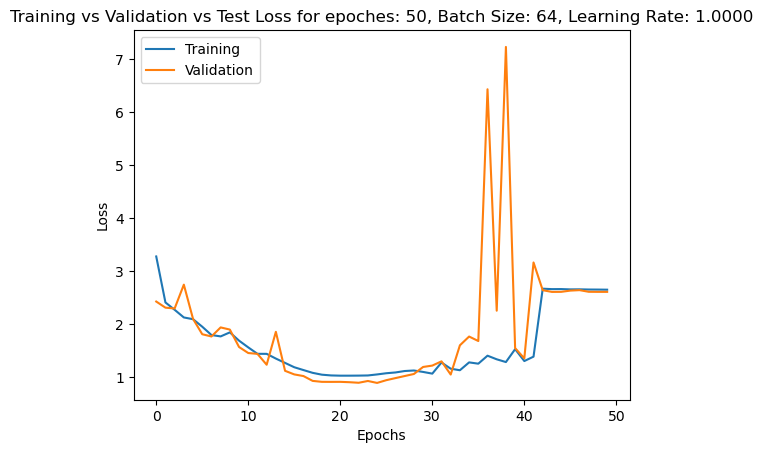

Learning Rate: 0.1000 
Batch Size: 64 
Epoch size: 50 
Epoch: 1 
Training Data: Epoch Loss: 2.009, Epoch Accuracy: 43.679, Validation Loss: 1.488,Validation Accuracy: 56.317
Epoch: 2 
Training Data: Epoch Loss: 0.977, Epoch Accuracy: 67.420, Validation Loss: 1.170,Validation Accuracy: 63.521
Epoch: 3 
Training Data: Epoch Loss: 0.645, Epoch Accuracy: 78.367, Validation Loss: 0.684,Validation Accuracy: 77.829
Epoch: 4 
Training Data: Epoch Loss: 0.435, Epoch Accuracy: 85.337, Validation Loss: 0.981,Validation Accuracy: 73.820
Epoch: 5 
Training Data: Epoch Loss: 0.327, Epoch Accuracy: 89.285, Validation Loss: 0.444,Validation Accuracy: 85.185
Epoch: 6 
Training Data: Epoch Loss: 0.243, Epoch Accuracy: 91.690, Validation Loss: 0.173,Validation Accuracy: 94.521
Epoch: 7 
Training Data: Epoch Loss: 0.182, Epoch Accuracy: 93.871, Validation Loss: 0.200,Validation Accuracy: 92.745
Epoch: 8 
Training Data: Epoch Loss: 0.136, Epoch Accuracy: 95.327, Validation Loss: 0.177,Validation Accuracy: 

In [ ]:
for n in lr:
    model = models.mobilenet_v2(pretrained=False, num_classes = 20)
    model.to(device)
    print("Learning Rate: %.4f "%(n))
    optimizer = torch.optim.SGD(model.parameters(), lr=n,momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)
    for Batch_size in Batchs:
        print("Batch Size: %d "%(Batch_size))
        training_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=Batch_size,shuffle=True,drop_last=False,num_workers=0)
        val_loader=torch.utils.data.DataLoader(dataset=val_dataset,batch_size=Batch_size,shuffle=False,drop_last=False,num_workers=0)
        n_epochs=50
        print("Epoch size: %d "%(n_epochs))
        epoch_count = 0
        Accuracies = [] 
        valAccuracies = []
        valLoss = []
        trainLoss = []
        t1 = time.time()
        validation_accuracy = 0
        for epoch in range(n_epochs):
            print("Epoch: %d "%(epoch+1))
            model.train()
            running_loss=0.0
            running_correct=0.0
            val_loss=0.0
            total=0
            for i,data in enumerate(training_loader):
                images,labels=data
                images=images.to(device)
                labels=labels.to(device)
                total+=labels.size(0)
                optimizer.zero_grad()
                outputs=model(images)
                _,predicted=torch.max(outputs.data,1)
                loss=criterion(outputs,labels)
                loss.backward()
                optimizer.step()
                running_loss+=loss.item()
                running_correct+=(labels==predicted).sum().item()
                traning_accuracy=(running_correct/total)*100
                    
            validation_accuracy=0
            model.eval()
            with torch.no_grad():
                val_correct=0
                val_total=0
                val_loss=0
                for data in val_loader:
                    images,val_labels=data[0].to(device), data[1].to(device)
                    images = images.to(device)
                    val_labels = val_labels.to(device)
                    outputs=model(images)
                    loss_val=criterion(outputs,val_labels)
                    val_loss+= loss_val.item()
                    _,predicted=torch.max(outputs.data,1)
                    val_correct+=(predicted == val_labels).sum().item()
                    val_total+=val_labels.size(0)
                validation_accuracy = (val_correct / val_total) *100
                    
            scheduler.step()
            epoch_loss=running_loss/len(training_loader)
            val_loss=val_loss/len(val_loader)
            epoch_accuracy=100.00* running_correct/total
            Accuracies.append(epoch_accuracy)
            valAccuracies.append(validation_accuracy)
            trainLoss.append(epoch_loss)
            valLoss.append(val_loss)
                
                
            print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f,Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
           
        
        print("######## epoch Finished in {} seconds ###########".format(time.time()\
                                                                    -t1))
        epoch_count+=n_epochs
        torch.save(model.state_dict(), "20-Class-MobileNetv2-"+str(epoch)+"_"+str(Batch_size)+"_"+str(n)+"-epoch.pt")
            
        plt.plot(range(n_epochs),Accuracies, label="Training")
        plt.plot(range(n_epochs),valAccuracies, label="Validation")
        plt.xlabel("Folds")
        plt.ylabel("Accuracies")
        plt.title("Training vs Validation vs Test Accuracies for epoches: %d, Batch Size: %d, Learning Rate: %.4f" % (n_epochs, Batch_size, n))
        plt.legend()
        plt.show()
            
        plt.plot(range(n_epochs),trainLoss, label="Training")
        plt.plot(range(n_epochs),valLoss, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation vs Test Loss for epoches: %d, Batch Size: %d, Learning Rate: %.4f" % (n_epochs, Batch_size, n))
        plt.legend()
        plt.show()
        
        lr_accuract_training.append(mean(Accuracies))
        lr_accuracy_val.append(mean(valAccuracies))
        lr_loss_train.append(mean(trainLoss))
        lr_loss_val.append(mean(valLoss))
            
        val=mean(valAccuracies)
        #Save the best model
        if val>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint.model')
            best_accuracy=val
            best_param="Learning Rate: "+str(n)+" Batch Size: "+str(Batch_size)+" "

In [ ]:
plt.plot(range(5),lr_accuract_training, label="Training")
plt.plot(range(5),lr_accuracy_val, label="Validation")
plt.xlabel("Folds")
plt.ylabel("Accuracies")
plt.title("Training vs Validation vs Test Accuracies with learning rate")
plt.legend()
plt.show()

In [ ]:
plt.plot(range(5),lr_loss_train, label="Training")
plt.plot(range(5),lr_loss_val, label="Validation")
plt.xlabel("Folds")
plt.ylabel("Accuracies")
plt.title("Training vs Validation vs Test Loss with learning rate")
plt.legend()
plt.show()

In [ ]:
print(best_param)

In [ ]:
model_path = 'best_checkpoint.model'

In [ ]:
state_dict = torch.load(model_path)

In [ ]:
model.load_state_dict(state_dict)

In [ ]:
testing_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [ ]:
evaluate_model(model,testing_loader)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [ ]:
y_pred = []
y_true = []

for data in testing_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = resnet18_Model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

In [ ]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(13,13)
plt.title("Confusion Matrix InceptionV3 (20-Classes)")
disp.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))